<a href="https://colab.research.google.com/github/bowwow-carrot/self_study_machine_learning-deep_learning/blob/main/4%EC%9D%BC%EC%B0%A8(%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8)_non_stopword.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
!pip install konlpy
 
프로젝트 주제 : 한국어 감정 분석기 
1 . 한국어 형태소 분석기를 활용한 , 전처리 
[[아 더빙 진짜 짜증, 0] , ['흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1\n']
train  = [[아, 더빙, 진짜, 짜증] , [흠 , .. , 포스터, 보, 고 , 초딩, 영화..].....]
label = [0,1.....]

2 . 각 토큰이 자주 등장한 단어 순위
2 - 1 각 단어(토큰) 의 빈도수 체크
 ex)
vindos['아'] = 3000
vindos['진짜'] = 4200

2 - 2 빈도수 큰것부터 인덱스화 
ex)
'진짜' = 0
'아' = 1
train = [[0,32,1,54],[1,8,3,23]]
label = [0,1]

2 - 3 인덱스와 value 매칭이 되는 vocab dictionary
아 정말 짜증난다 -> [0,1,2,3]

---- 전처리 종료 ----------
3 - 1
sklearn - train, test split,  위 전처리한 파일을 분리
8 : 2
-> 코드제출
-> 예시 제출

3 - 2
학습 진행 , 
vocab size, sequence 길이 조절
model epoch 10
validation data accuracy 57% 
-> 제출 로그파일 

"""
print()

In [6]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 448 kB 56.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [7]:
import os
import os.path as pth

#설명 추가해야됨.
from glob import glob

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from sklearn.model_selection import train_test_split as tts
from keras.preprocessing.sequence import pad_sequences as p_seq
from tensorflow.keras.optimizers import Adam as adam
from keras import layers, models

from konlpy.tag import  Komoran
import matplotlib.pyplot as plt
import numpy as np

In [8]:
MODEL_NAME = 'RNN_test'
MODEL_PATH = '/content/drive/MyDrive/ai_project/RNN_project_data/'

In [9]:
komoran = Komoran()

#/content/drive/MyDrive/ai_project/ratings_train.txt
#/content/ratings_train.txt
# 에러코드정리
#   UnicodeDecodeError: 'utf-8' codec can't decode byte 0xec in position 0: unexpected end of data :: UTF-16 코드
#     xFF xFE(0xFFFE)는 BOM(Byte order Mark)라고 한다고 한다.
#     16비트 문자의 경우 빅엔디안(0xFE FF)인지, 리틀엔디안(0xFF FE)인지를 구분하기 위한 헤더
#   UnicodeError: UTF-16 stream does not start with BOM :: cp949 인코드
with open('/content/drive/MyDrive/ai_project/ratings_train_utf8(DOM).txt', mode='r',encoding='UTF-8') as data:
  all_line = data.readlines()
  train = [] #앞으로의 y 값
  label = []
  vocab = []
  #'id\tdocument\tlabel\n', '9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0\n',
  count = 0
  for i in all_line :
    if count == 20000: #layers.Embedding(max_features, 128)(x) 에 크기를 맞춰줘야됨.
      break
    i = i.split('\t')
    # [id, document,label]
    vocab.append(i[1])
    token=komoran.morphs(i[1]) #morphs 로 내용 학습
    train.append(token)
    label_num=i[2].rstrip('\n') 
    label.append(label_num)
    count = count + 1

In [10]:
# 주 목표 : 위의 x_train과 y_train처럼 만들어주는 것이 목표.
#2 - 1 각 단어(토큰) 의 빈도수 체크
vindos = {}
for i in train:
  for j in i :
    if j in vindos:
      vindos[j] = vindos[j]+1
    else :
      vindos[j] = 1

vindos_list1 = [[k,v] for k, v in zip(vindos.keys(),vindos.values())]
vindos_key = list(vindos)
vindos_val = list(vindos.values())


#2 - 2 빈도수 큰것부터 인덱스화 
test_train = [[vindos[j] for j in i] for i in train]
for i in test_train:
  i.sort(reverse=True)

#2 - 3 인덱스와 value 매칭이 되는 vocab dictionary
#아 정말 짜증난다 -> [0,1,2,3]

vocab_dict = {k:v for k,v in zip(vocab, test_train)}

In [5]:
#2 - 3 인덱스와 value 매칭이 되는 vocab dictionary

#test_train

#test_dict = {'아 정말 짜증난다' : [0,1,2,3]}
#test_dict = {'test':test_train[2]}
#test_dict

#vocab_dict = {k:v for k,v in zip(vocab, test_train)}
#vocab_dict

In [20]:
#3 - 1 sklearn - train, test split,  위 전처리한 파일을 분리 8 : 2 -> 코드제출 -> 예시 제출
"""
from sklearn.model_selection import train_test_split as tts
from keras.preprocessing.sequence import pad_sequences as p_seq
from tensorflow.keras.optimizers import Adam as adam
from keras import layers, models
import numpy as np

import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
"""
#TPU 사용
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

# 훈련을 여러 GPU 또는 여러 장비, 여러 TPU로 나누어 처리하기 위한 텐서플로 API
strategy = tf.distribute.TPUStrategy(resolver)

max_features=20000
maxlen=100

test_label = np.array(label, dtype='int')
x_train, x_test, y_train, y_test = tts(test_train, test_label, test_size=0.2, random_state=42)
print(f"x_train:{len(x_train)}, y_train:{len(y_train)}, x_test:{len(x_test)}, y_test:{len(y_test)}")
x_train = p_seq(x_train, maxlen=maxlen)
x_test = p_seq(x_test, maxlen=maxlen)
#y_train = np.array(y_train, dtype='int')
#y_test = np.array(y_test, dtype='int')
print(f"x_train:{len(x_train)}, y_train:{len(y_train)}, x_test:{len(x_test)}, y_test:{len(y_test)}")

#3 - 2 학습 진행 , vocab size, sequence 길이 조절 model epoch 10 validation data accuracy 57%  -> 제출 로그파일 
#x = layers.Input((maxlen,)) #maxlen만큼 입력노드 생성
#h = layers.Embedding(max_features, 128)(x)
#h = layers.SimpleRNN(128)(h)
#y = layers.Dense(1, activation='sigmoid')(h)

#model = models.Model(x,y)



#keras.optimizers.Adam()
# Learning rate 0.1
# beta 1, 2 => beta 1 Momentum 0.9 ,  beta 2 Adagrad 0.99
# epsilon => Adagrad 분모 가 0 되는 것을 방지하기 위한 파라메터 0.00001
# decay => Learning rate 1 epoch 진행 마다 Decay 비율만큼 감소 0.01 or 0.0
# Learning rate = 0.1 , decay 0.01 
# 1 Epoch LR  = 0.1
# 2 Epoch LR  = 0.09

#adam의 옵션!!
#keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,epsilon=none,amsgrad=False)
# epochs = 4 => 
"""
learning_rate: 0보다 크거나 같은 float 값. 학습률.
beta_1: 0보다 크고 1보다 작은 float 값. 일반적으로 1에 가깝게 설정됩니다.
beta_2: 0보다 크고 1보다 작은 float 값. 일반적으로 1에 가깝게 설정됩니다.
epsilon: 0보다 크거나 같은 float형 fuzz factor. None인 경우 K.epsilon()이 사용됩니다.
decay: 0보다 크거나 같은 float 값. 업데이트마다 적용되는 학습률의 감소율입니다.
amsgrad: 불리언. Adam의 변형인 AMSGrad의 적용 여부를 설정합니다. AMSGrad는 "On the Convergence of Adam and Beyond" 논문에서 소개되었습니다.
"""

with strategy.scope():
  x = layers.Input((maxlen,)) #maxlen만큼 입력노드 생성
  h = layers.Embedding(max_features, 128)(x)
  h = layers.SimpleRNN(128)(h)
  y = layers.Dense(1, activation='sigmoid')(h)
  model = models.Model(x,y)
  model.compile(loss='binary_crossentropy',optimizer=adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.001),metrics=['accuracy'])

#val_loss가 적은 값이 적은 모델 저장
checkpoint_path = pth.join(MODEL_PATH, MODEL_NAME)
os.makedirs(checkpoint_path, exist_ok=True)
model_file_path = pth.join(checkpoint_path, 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)

# {patience}회간 val_loss가 좋아지지 않으면 중지.
#early_stopping = EarlyStopping(monitor='val_loss',patience=30)

batch_size = 1000
epochs = 300
history = model.fit(x_train, y_train,
           batch_size = batch_size,
           epochs = epochs,
           validation_data=(x_test, y_test),
           #callbacks=[checkpoint, early_stopping],
           callbacks=[checkpoint],
           )

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.38.166.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.166.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


x_train:16000, y_train:16000, x_test:4000, y_test:4000
x_train:16000, y_train:16000, x_test:4000, y_test:4000
Epoch 1/300
16/16 [==============================] - 5s 107ms/step - loss: 0.7302 - accuracy: 0.4978 - val_loss: 0.6975 - val_accuracy: 0.4930

Epoch 00001: val_loss improved from inf to 0.69753, saving model to /content/drive/MyDrive/ai_project/RNN_project_data/RNN_test/Epoch_001_Val_0.698.hdf5
Epoch 2/300
16/16 [==============================] - 2s 114ms/step - loss: 0.6900 - accuracy: 0.5218 - val_loss: 0.6831 - val_accuracy: 0.5483

Epoch 00002: val_loss improved from 0.69753 to 0.68315, saving model to /content/drive/MyDrive/ai_project/RNN_project_data/RNN_test/Epoch_002_Val_0.683.hdf5
Epoch 3/300
16/16 [==============================] - 1s 57ms/step - loss: 0.6485 - accuracy: 0.6072 - val_loss: 0.6906 - val_accuracy: 0.6455

Epoch 00003: val_loss did not improve from 0.68315
Epoch 4/300
16/16 [==============================] - 1s 57ms/step - loss: 0.6909 - accuracy: 0.550

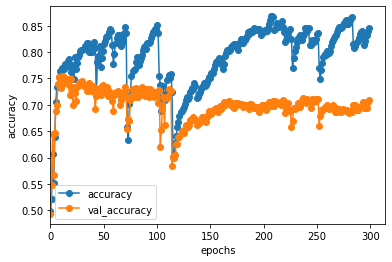

In [21]:
# 훈련 결과를 확인
plt.plot(history.epoch, history.history['accuracy'], '-o', label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], '-o', label='val_accuracy')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
"학습 기록장"

#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
## batch_size = 10, epochs = 8 =>loss:  0.5526 - accuracy: 0.7073
## batch_size = 20, epochs = 4 => loss: 0.4978 - accuracy: 0.7573
## batch_size = 20, epochs = 8 => loss: 0.4747 - accuracy: 0.7741
## batch_size = 20, epochs = 20=> loss: 0.5539 - accuracy: 0.7261 //50s
## batch_size = 32. epochs = 10=> 9/10 : loss: 0.4586 - accuracy: 0.7797, 10/10 : loss: 0.5709 - accuracy: 0.6973
## batch_size = 64. epochs = 4 => loss: 0.5084 - accuracy: 0.7492
## batch_size = 64. epochs = 8 => loss: 0.5062 - accuracy: 0.7529
## batch_size = no. epochs = 9 => loss: 0.5385 - accuracy: 0.7337
## batch_size = 110, epochs = 20 => loss: 0.2075 - accuracy: 0.9121 - val_loss: 0.9605 - val_accuracy: 0.7003 //18s overfitting epochs 5 best
## batch_size = 120, epochs = 5  => loss: 0.4071 - accuracy: 0.8126 - val_loss: 0.5647 - val_accuracy: 0.7135 //17s overfitting epochs 2 best
## batch_size = 120, epochs = 20 => loss: 0.2212 - accuracy: 0.9061 - val_loss: 0.9623 - val_accuracy: 0.7232 //15s overfitting
## batch_size = 200, epochs = 30 => loss: 0.3781 - accuracy: 0.8256 - val_loss: 0.5760 - val_accuracy: 0.7368 //16s overfitting epochs 20 best
## batch_size = 200, epochs = 20 => loss: 0.2351 - accuracy: 0.8979 - val_loss: 0.9516 - val_accuracy: 0.7185 //16s overfitting epochs 4 best
#model.compile(loss='binary_crossentropy',optimizer=adam(learning_rate=0.1, beta_1=0.99, beta_2=0.99, epsilon=0.00001, decay=0.0, amsgrad=False),metrics=['accuracy'])
## batch_size = 20, epochs = 4 => loss: 1.0007 - accuracy: 0.5050
#model.compile(loss='binary_crossentropy',optimizer=adam(beta_1=0.99),metrics=['accuracy'])
## batch_size = 20, epochs = 4 => loss: 0.5551 - accuracy: 0.7246
## batch_size = 20, epochs = 8 => loss: 0.5563 - accuracy: 0.7134
#model.compile(loss='binary_crossentropy',optimizer=adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,amsgrad=False),metrics=['accuracy'])
## batch_size = 20, epochs = 4 => loss: 0.5014 - accuracy: 0.7529
#model.compile(loss='binary_crossentropy',optimizer=adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01),metrics=['accuracy'])
## batch_size = 120, epochs = 30 => loss: 0.3883 - accuracy: 0.8248 - val_loss: 0.5389 - val_accuracy: 0.7400
#model.compile(loss='binary_crossentropy',optimizer=adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, decay=0.01),metrics=['accuracy'])
## batch_size = 120, epochs = 50 => loss: 0.5610 - accuracy: 0.6850 - val_loss: 0.7416 - val_accuracy: 0.5410 //15s underfitting
## batch_size = 300, epochs = 5  => loss: 0.6962 - accuracy: 0.5366 - val_loss: 0.7145 - val_accuracy: 0.4980 //12s underfitting
## batch_size = 500, epochs = 5  => loss: 0.7006 - accuracy: 0.5210 - val_loss: 0.7004 - val_accuracy: 0.5205 //12s underfitting
## batch_size = 1000, epochs = 5 => loss: 0.6795 - accuracy: 0.5429 - val_loss: 0.6792 - val_accuracy: 0.5395 //10s underfitting
## batch_size = 2000, epochs = 5 => loss: 0.7091 - accuracy: 0.5132 - val_loss: 0.7091 - val_accuracy: 0.4902 //12s underfitting
## batch_size = 1000, epochs = 50 => loss: 0.5210 - accuracy: 0.7422 - val_loss: 0.5430 - val_accuracy: 0.7335
## batch_size = 1000, epochs = 100 => loss: 0.5506 - accuracy: 0.7003 - val_loss: 0.6662 - val_accuracy: 0.6245

In [22]:
#가장 좋은 모델의 가중치 불러오기
checkpoint_path = pth.join(MODEL_PATH, MODEL_NAME)
weigth_file = glob('{}/*.hdf5'.format(checkpoint_path))[-1]
print(weigth_file)
model.load_weights(weigth_file)

/content/drive/MyDrive/ai_project/RNN_project_data/RNN_test/Epoch_017_Val_0.508.hdf5


In [30]:
vindos

{'아': 2660,
 '더빙': 64,
 '.': 15368,
 '진짜': 1051,
 '짜증': 190,
 '나': 2043,
 '네요': 983,
 '목소리': 37,
 '흠': 40,
 '...': 3392,
 '포스터': 85,
 '보고': 195,
 '초딩': 50,
 '영화': 7068,
 '줄': 246,
 '....': 286,
 '오버': 16,
 '연기': 962,
 '조차': 41,
 '가볍': 48,
 '지': 2719,
 '않': 968,
 '구나': 90,
 '너무재밓었다그래서보는것을추천한다': 1,
 '교도소': 3,
 '이야기': 272,
 '이': 13301,
 '구먼': 5,
 '..': 1076,
 '솔직히': 148,
 '재미': 500,
 '는': 8723,
 '없': 2083,
 '다': 7089,
 '평점': 836,
 '조정': 6,
 '사이몬페그의': 1,
 '익살': 3,
 '스럽': 330,
 'ㄴ': 9641,
 '가': 4277,
 '돋보이': 43,
 '었': 3287,
 '던': 757,
 '!': 1576,
 '스파이더맨': 15,
 '에서': 1050,
 '늙': 18,
 '어': 2931,
 '보이': 360,
 '기': 1285,
 '만': 1591,
 '하': 12721,
 '았': 3940,
 '커스틴 던스트': 1,
 '너무나': 94,
 '도': 4193,
 '이뻐보였다': 1,
 '막': 68,
 '걸음마': 1,
 '떼': 30,
 '3': 299,
 '세': 162,
 '부터': 261,
 '초등학교': 17,
 '1': 712,
 '학년': 18,
 '생': 67,
 '8살용영화.ㅋㅋㅋ...별반개도': 1,
 '아깝': 597,
 'ㅁ': 2089,
 '원작': 168,
 '의': 4270,
 '긴장감': 115,
 '을': 4085,
 '제대로': 96,
 '살리': 61,
 '내': 1070,
 '못하': 403,
 '별': 204,
 '반개': 30,
 '욕': 127,
 '나

In [34]:
#3-4 predict input text = '안녕하세요 여러분'
#=> preprocessing -> [0,3]
#=> seqlength = 100
#output => 0.63 -> 긍정에 가까운거.

sentence = '오 감사합니다 신기하네요'
tokens=komoran.morphs(sentence)

voca_list = []
for token in tokens:
  voca_list.append(vindos[token])

voca_list = [voca_list]  # Tensor 형태로 변환

print(voca_list)
voca_list=p_seq(voca_list, maxlen=maxlen)
model.predict(voca_list)

[[529, 55, 12721, 804, 33, 12721, 983]]


array([[0.6263014]], dtype=float32)

In [ ]:
"""
불용어, 자주 등장하지 않았던, 
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '.', '..',
                 '...', '을', '에서', '로', '것','주륵주륵','좔좔','아','휴','아이구','아이쿠','아이구','어','나','우리','저희']
단어에 대해서 제거
등장 횟수가 3회 미만 ->
성능 비교
하기전 : 78 %
한 후 : 79 %
불용어 제거 코드 , 성능 비교표 
귓속말로 제출 
"""